# Risk Analysis Pipeline

## 1. Setup and Imports

In [1]:
# If you have conda installed, you can run the following commands:
# conda env create -f environment.yml
# conda activate 

# Add src directory to Python path
import os
import sys
src_dir = os.path.join(os.getcwd(), 'src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
# Add src necessary directories
os.makedirs(os.path.join(os.getcwd(), 'data/processed'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'outputs'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'outputs/charts'), exist_ok=True)
os.makedirs(os.path.join(os.getcwd(), 'outputs/tables'), exist_ok=True)

# Careful, if you ran with docker first you will have permission issues with the data directory, so you might need to change the permissions manually. Simply run:
# sudo chmod -R 777 data
# sudo chmod -R 777 outputs
# If you didn't run docker, ignore this step.

# Import required modules
from src.data_loader import DataLoader
from src.visulaizer import Visualizer
from src.risk_analyzer import RiskAnalyzer

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All modules imported successfully")

✅ All modules imported successfully


## 2. Data Loading and Preparation

In [3]:
# Initialize data loader
data_loader = DataLoader(xlsx_file_dir="data/raw", output_dir="data/processed")

# We first merge the file into one by using a left join as required in question 1
data_loader.merge_all_data()

print("✅ Data loader initialized")

✅ Data loader initialized


## 3. Country of origin by sector Analysis

First, we plot the country of origin for each client by sector, to determine the proportion of clients that are outside of luxembourg. Here the "REGION" column is important

In [4]:
# Load data for regional analysis
regional_data = data_loader.open_merged_data(columns=["SURVEY_ID", "SECTOR", "REGION"])
regional_data_table =regional_data.drop_duplicates(subset="SURVEY_ID").reset_index(drop=True)

# Display basic info
print(f"Dataset shape: {regional_data_table.shape}")
print(f"\nColumns: {list(regional_data_table.columns)}")
print(f"\nFirst few rows:")
regional_data.head()

Dataset shape: (1861, 3)

Columns: ['SURVEY_ID', 'SECTOR', 'REGION']

First few rows:


,SURVEY_ID,SECTOR,REGION
0,2925330,ECO,LU
1,2925330,ECO,LU
2,2925330,ECO,LU
3,2925420,SERVICE,LU
4,2925420,SERVICE,LU



📊 Regional Distribution Summary:
REGION
LU        9595
NON LU    4613
Name: count, dtype: int64

📊 Sector Distribution Summary:
SECTOR
IMMO       8207
ECO        5175
SERVICE     838
Name: count, dtype: int64


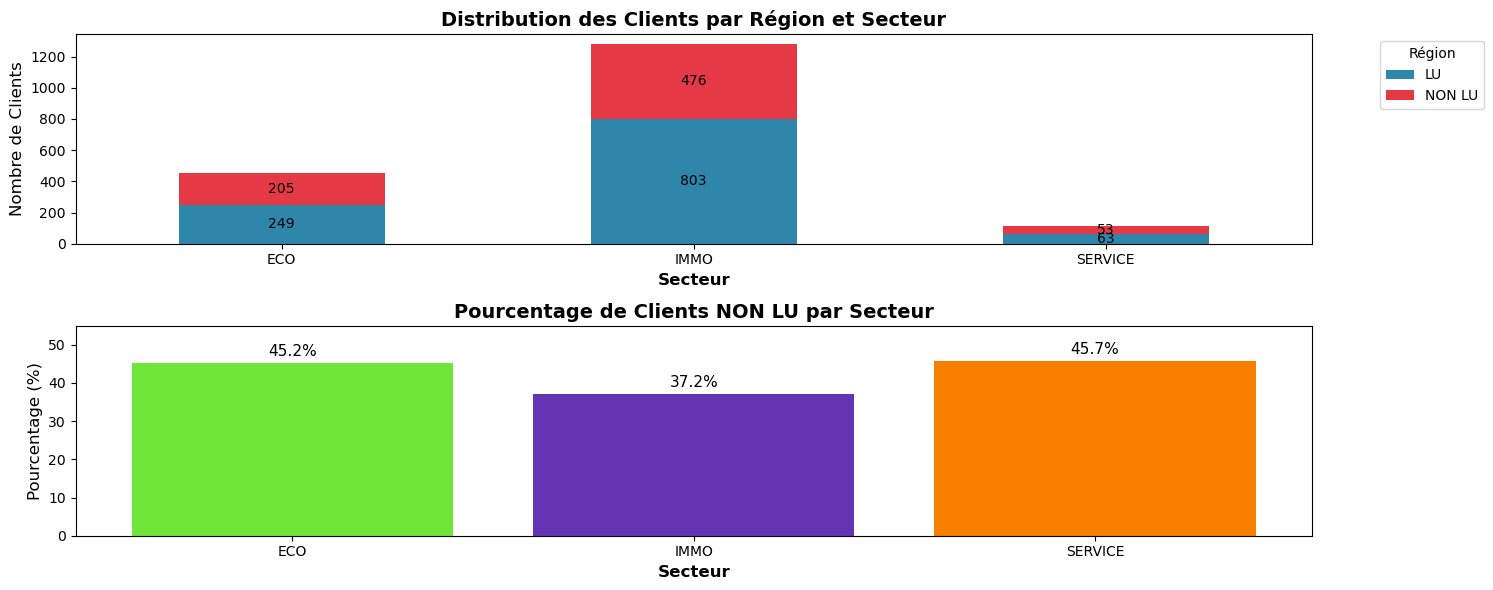

In [5]:
# Create regional visualization
visualizer = Visualizer(regional_data)
visualizer.plot_region_by_sector()

# Display summary statistics
print("\n📊 Regional Distribution Summary:")
print(regional_data['REGION'].value_counts())
print("\n📊 Sector Distribution Summary:")
print(regional_data['SECTOR'].value_counts())

## 4. Suspect Operations Analysis

Here I analysed the refusals and stoppages of a business relationship. I also visualized the number of clients that refused to enter into a business relationship and also didn't fill out a DOS. These are especially risky clients

In [6]:
# Load data for suspect operations analysis
suspect_data = data_loader.open_merged_data(
    columns=[
        "SURVEY_ID",
        "SECTOR",
        "BU_REL_REFUSAL",
        "BU_REL_TERM",
        "SUSP_TRANS_SURVEY",
    ])

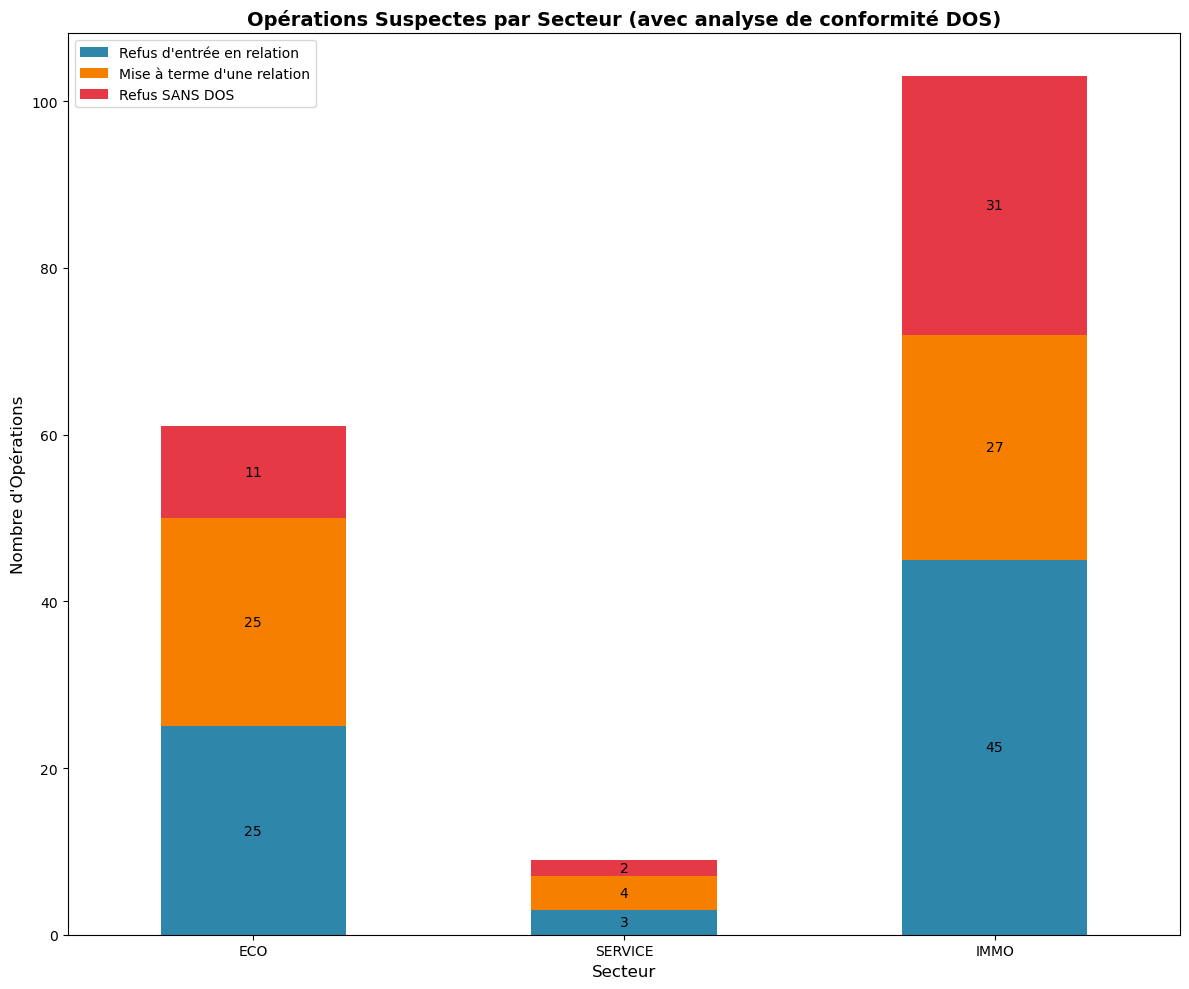

In [7]:
# Visualize suspect operations by sector
visualizer = Visualizer(suspect_data)
visualizer.plot_suspect_operations_by_sector()


## 5. Identification Compliance Analysis

Examining client and beneficiary identification compliance across sectors. Here I assigned a risk value based on the status of both parties. If both had "AVANCEE" or "SIMPLE", I assigned "AVANCEE" or "SIMPLE" respectively. However, if these diverged I considered the client to be a risk ("RISK"), since the identification compliances are not homogenous

In [8]:
# Load identification compliance data
id_compliance_data = data_loader.open_merged_data(
    columns=["SURVEY_ID", "SECTOR", "CLIENT_ID_STATUS", "BENIFICIARY_ID_STATUS"]
)

id_compliance_data_table = id_compliance_data.drop_duplicates(subset="SURVEY_ID").reset_index(drop=True)

print(f"ID compliance dataset shape: {id_compliance_data_table.shape}")
id_compliance_data.head()

ID compliance dataset shape: (1861, 4)


,SURVEY_ID,SECTOR,CLIENT_ID_STATUS,BENIFICIARY_ID_STATUS
0,2925330,ECO,SIMPLE,None
1,2925330,ECO,SIMPLE,None
2,2925330,ECO,SIMPLE,None
3,2925420,SERVICE,AVANCEE,AVANCEE
4,2925420,SERVICE,AVANCEE,AVANCEE



🆔 Identification Compliance Summary:

Client ID Status:
CLIENT_ID_STATUS
AVANCEE    1258
SIMPLE      510
Name: count, dtype: int64

Beneficiary ID Status:
BENIFICIARY_ID_STATUS
AVANCEE    1189
SIMPLE      417
Name: count, dtype: int64


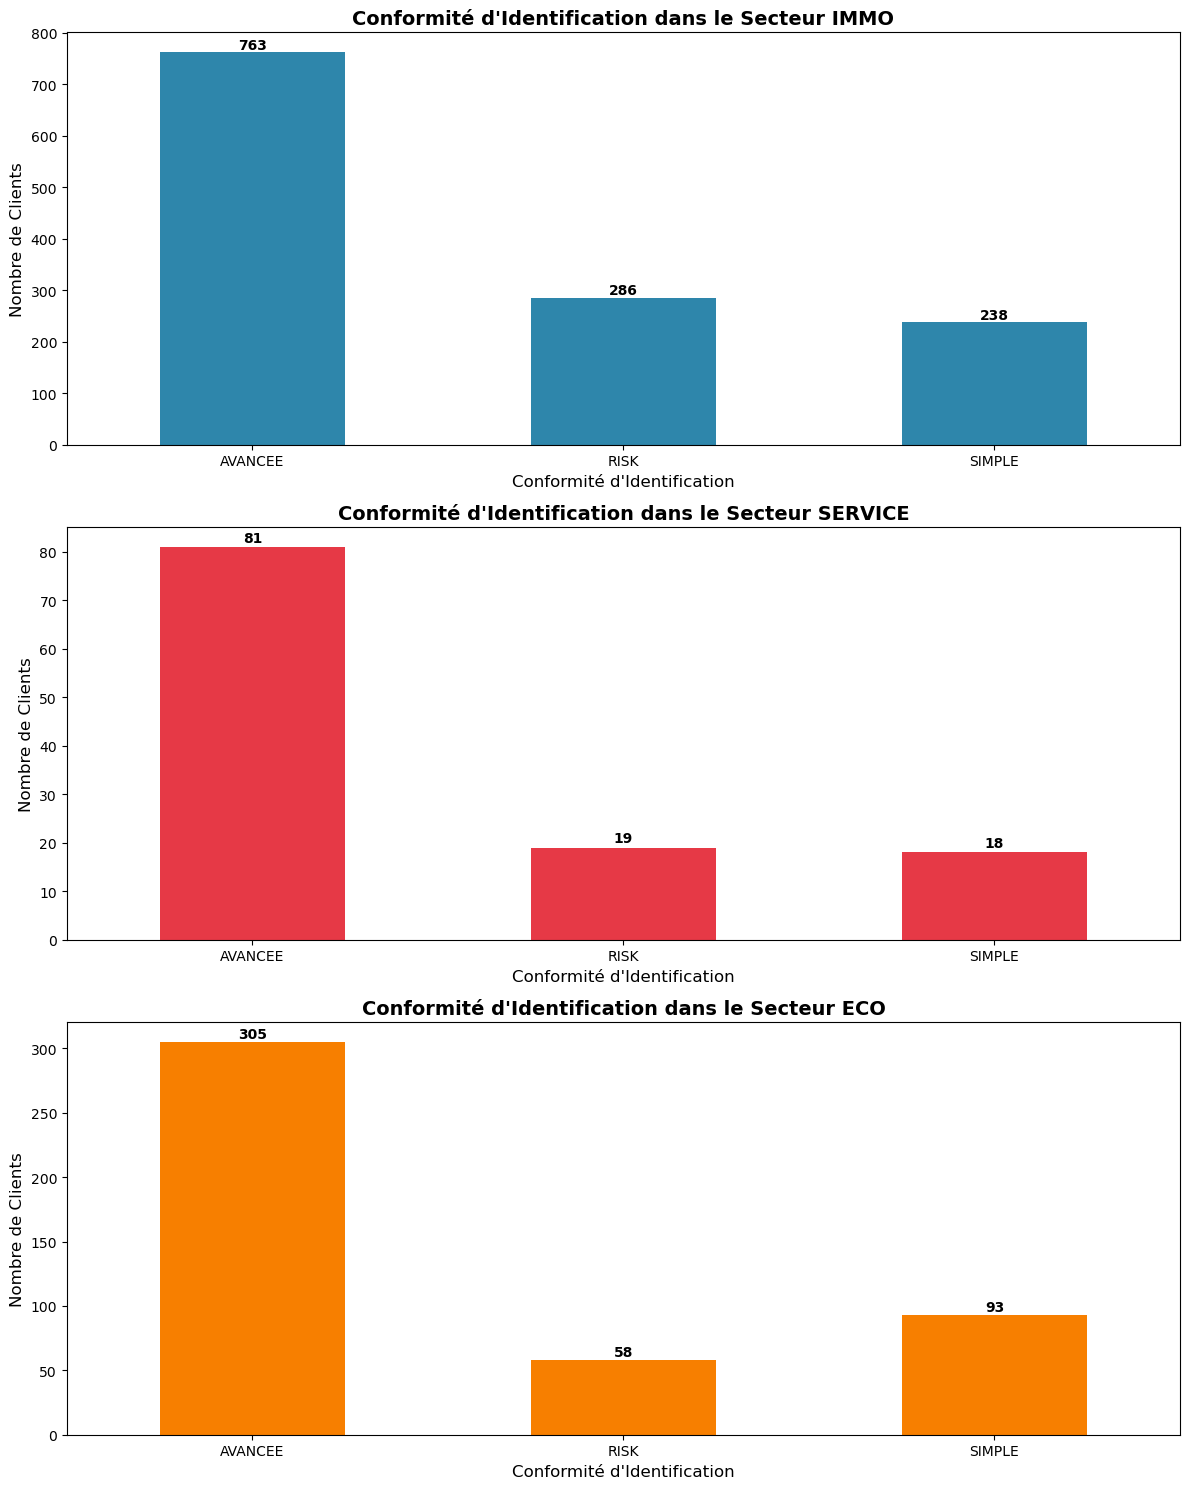

In [9]:
# Visualize identification compliance
visualizer = Visualizer(id_compliance_data)
visualizer.plot_identification_compliance()

# Compliance summary
print("\n🆔 Identification Compliance Summary:")
print("\nClient ID Status:")
print(id_compliance_data_table['CLIENT_ID_STATUS'].value_counts())
print("\nBeneficiary ID Status:")
print(id_compliance_data_table['BENIFICIARY_ID_STATUS'].value_counts())

## 6. Document Archiving Compliance

Analyzing document archiving practices across different sectors. Here I considered all the entries that had a document archiving below 5A to be non compliant "Non conforme", all others are compliant (conforme).

In [10]:
# Load document archiving data
archiving_data = data_loader.open_merged_data(
    columns=["SURVEY_ID", "SECTOR", "DOCUMENT_ARCHIVING"]
)

archiving_data_table = archiving_data.drop_duplicates(subset="SURVEY_ID").reset_index(drop=True)

print(f"Document archiving dataset shape: {archiving_data_table.shape}")
archiving_data.head()

Document archiving dataset shape: (1861, 3)


,SURVEY_ID,SECTOR,DOCUMENT_ARCHIVING
0,2925330,ECO,None
1,2925330,ECO,None
2,2925330,ECO,None
3,2925420,SERVICE,5A
4,2925420,SERVICE,5A


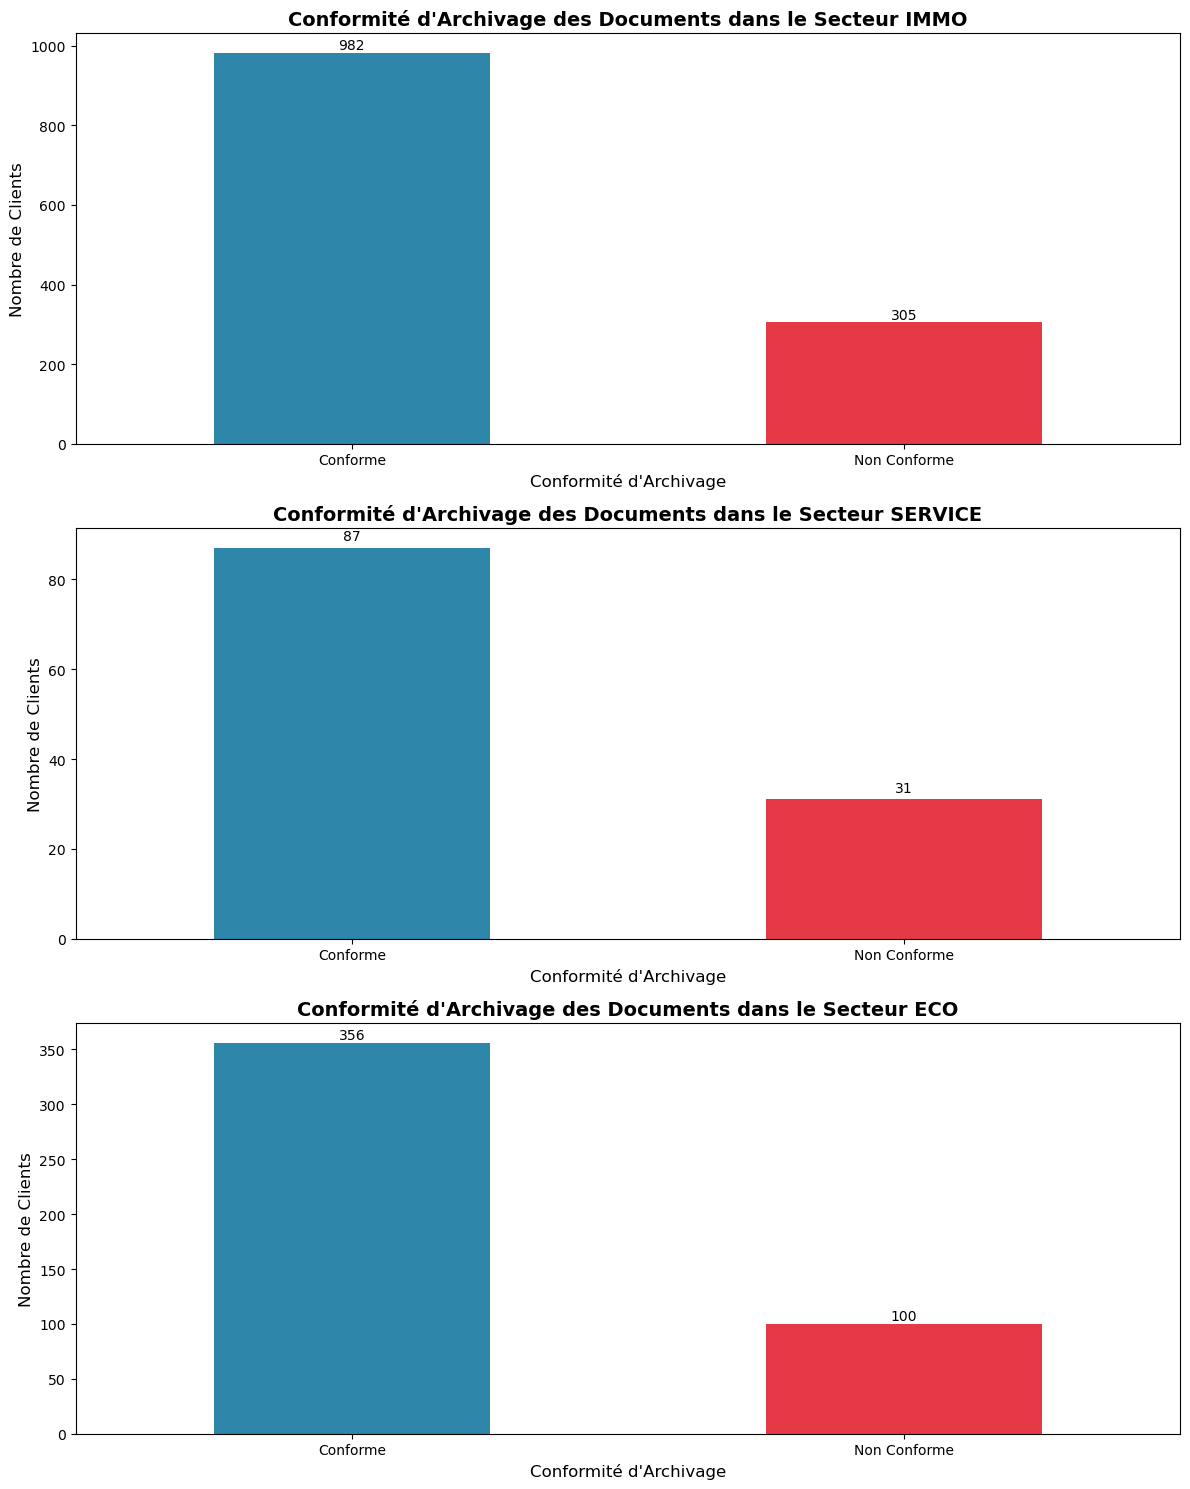

In [11]:
# Visualize document archiving compliance
visualizer = Visualizer(archiving_data)
visualizer.plot_document_archiving_compliance_by_sector()

## 7. Cash Transactions Analysis

Examining payment methods and cash transaction patterns by sector. Here I considered a client to be risky if he did even just one payment with cash. 

Table cash_transactions_by_sector_summary.xlsx has also the percentages of clients that used cash transactions.

In [12]:
# Load payment method data
payment_data = data_loader.open_merged_data(
    columns=["SURVEY_ID", "SECTOR", "PAYMENT_METHOD"]
)

print(f"Payment method dataset shape: {payment_data.shape}")
payment_data.head()

Payment method dataset shape: (14220, 3)


,SURVEY_ID,SECTOR,PAYMENT_METHOD
0,2925330,ECO,VIR
1,2925330,ECO,VIR
2,2925330,ECO,VIR
3,2925420,SERVICE,VIR
4,2925420,SERVICE,VIR


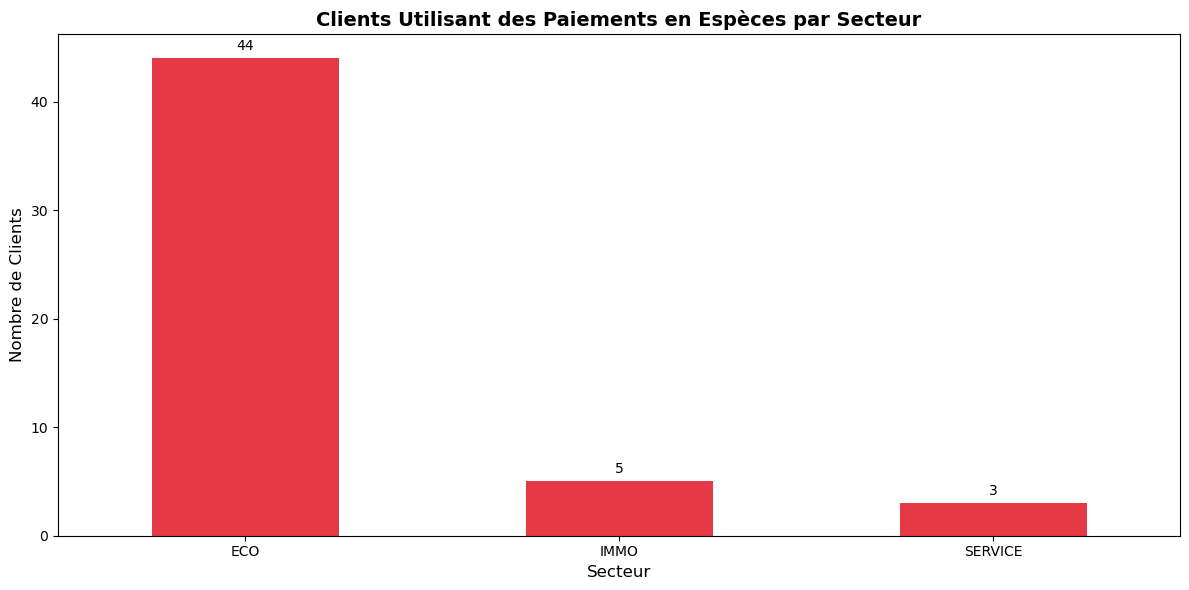

In [13]:
# Visualize cash transactions by sector
visualizer = Visualizer(payment_data)
visualizer.plot_cash_transactions_by_sector()

## 8. High-Risk Revenue Analysis

Analyzing revenue types and transaction volumes to identify high-risk patterns. Here I considered all the clients with transaction numbers in the 75th percentile to be risky. Notably "SERV_VIRTUEL" has no clients that deal in these dervices and the numbers of clients that do any of the high risk services is fairly low. Table high_risk_revenue_complete_summary.xlsx has the full numbers as well as a further basic analysis of the number of transactions distribution in sheet 2. Additionally only 191, corresponding to 14% of the clients, have a high risk amount of transactions.


In [14]:
# Load revenue and transaction data
revenue_data = data_loader.open_merged_data(
    columns=["SURVEY_ID", "SECTOR", "REVENUE_KIND", "NB_TRANSACTIONS"]
)

print(f"Revenue analysis dataset shape: {revenue_data.shape}")
revenue_data.head()

Revenue analysis dataset shape: (14220, 4)


,SURVEY_ID,SECTOR,REVENUE_KIND,NB_TRANSACTIONS
0,2925330,ECO,ECO_COMPTABILIT,0.0
1,2925330,ECO,ECO_COMPTABILIT,0.0
2,2925330,ECO,ECO_COMPTABILIT,0.0
3,2925420,SERVICE,SERV_COMPTABILI,0.0
4,2925420,SERVICE,SERV_COMPTABILI,0.0


In [15]:
# Summarize high-risk revenue by sector
visualizer = Visualizer(revenue_data)
visualizer.summarize_high_risk_revenue_by_sector()

# Revenue summary statistics
print("\n📈 Revenue Analysis Summary:")
print("\nSERV_CREATION_S revenue type clients:")
print(revenue_data[revenue_data['REVENUE_KIND'] == 'SERV_CREATION_S'].value_counts())
print("\nSERV_FONCTION revenue type clients:")
print(revenue_data[revenue_data['REVENUE_KIND'] == 'SERV_FONCTION'].value_counts())
print("\n SERV_VIRTUEL revenue type clients:")
print(revenue_data[revenue_data['REVENUE_KIND'] == 'SERV_VIRTUEL'].value_counts())
print("\nOther revenue types:")
print(revenue_data["REVENUE_KIND"].value_counts())

print("\nTransaction Volume Statistics:")
print(revenue_data['NB_TRANSACTIONS'].describe())


📈 Revenue Analysis Summary:

SERV_CREATION_S revenue type clients:
SURVEY_ID  SECTOR   REVENUE_KIND     NB_TRANSACTIONS
6573528    SERVICE  SERV_CREATION_S  0.0                9
6600113    SERVICE  SERV_CREATION_S  0.0                6
7460466    SERVICE  SERV_CREATION_S  0.0                6
7537184    SERVICE  SERV_CREATION_S  0.0                6
18001951   SERVICE  SERV_CREATION_S  0.0                6
3748461    SERVICE  SERV_CREATION_S  0.0                3
10587011   SERVICE  SERV_CREATION_S  0.0                3
18028367   SERVICE  SERV_CREATION_S  0.0                3
Name: count, dtype: int64

SERV_FONCTION revenue type clients:
SURVEY_ID  SECTOR   REVENUE_KIND   NB_TRANSACTIONS
6587947    SERVICE  SERV_FONCTION  0.0                6
6876476    SERVICE  SERV_FONCTION  0.0                6
7005309    SERVICE  SERV_FONCTION  0.0                6
7011140    SERVICE  SERV_FONCTION  0.0                6
7293943    SERVICE  SERV_FONCTION  0.0                6
7460466    SERVICE  S

## 9. Comprehensive Risk Assessment

Computing overall risk scores and identifying high-risk clients based on multiple factors. Finally, we can put everything together and perform a risk analysis for each client. The RiskAnalyzer class takes care of most of the work where we format and add new columns based on what we have seen before. Please refer to the comments in the risk_analyzer.py file to see what exactly happens to each column.

So for each row we can calculate a risk score based on the following criteria:

- BU_REL_REFUSAL: if 'Y' then +1

- BU_REL_TERM: if 'Y' then +1

- IDENTIFICATION_COMPLIANCE: if 'RISK' then +1

- ARCHIVING_COMPLIANCE: if 'Non Conforme' then +1

- REGION_RISK: if 'NON LU' then +1

- PAYMENT_METHOD: if 'CASH' then +1

- REVENUE_KIND: if 'SERV_CREATION_S', 'SERV_FONCTION', 'SERV_VIRTUEL' then +1

- NB_TRANSACTIONS: if > 61 then +1

- If any cell is NaN, we will not count it as a risk factor.

This will give us a total possible risk score of 8

Our analysis shows that 21 clients are high risk, which can be seen in the risk_assessment_summary.xlsx file.

In [16]:
# Initialize risk analyzer
risk_analyzer = RiskAnalyzer(data_loader)

# Calculate risk scores
risk_data = risk_analyzer.calculate_risk_scores()

print(f"\nRisk assessment dataset shape: {risk_data.shape}")
print(f"\nColumns in risk dataset: {list(risk_data.columns)}")
risk_data.head()


Risk assessment dataset shape: (14220, 12)

Columns in risk dataset: ['SURVEY_ID', 'SECTOR', 'REGION_RISK', 'BU_REL_REFUSAL', 'BU_REL_TERM', 'IDENTIFICATION_COMPLIANCE', 'ARCHIVING_COMPLIANCE', 'PAYMENT_METHOD', 'REVENUE_KIND', 'NB_TRANSACTIONS', 'RISK_SCORE', 'RISK_CATEGORY']


,SURVEY_ID,SECTOR,REGION_RISK,BU_REL_REFUSAL,BU_REL_TERM,IDENTIFICATION_COMPLIANCE,ARCHIVING_COMPLIANCE,PAYMENT_METHOD,REVENUE_KIND,NB_TRANSACTIONS,RISK_SCORE,RISK_CATEGORY
0,2925330,ECO,LU,N,N,RISK,Non Conforme,VIR,ECO_COMPTABILIT,0.0,2,Medium
1,2925330,ECO,LU,N,N,RISK,Non Conforme,VIR,ECO_COMPTABILIT,0.0,2,Medium
2,2925330,ECO,LU,N,N,RISK,Non Conforme,VIR,ECO_COMPTABILIT,0.0,2,Medium
3,2925420,SERVICE,LU,N,N,AVANCEE,Conforme,VIR,SERV_COMPTABILI,0.0,0,Low
4,2925420,SERVICE,LU,N,N,AVANCEE,Conforme,VIR,SERV_COMPTABILI,0.0,0,Low


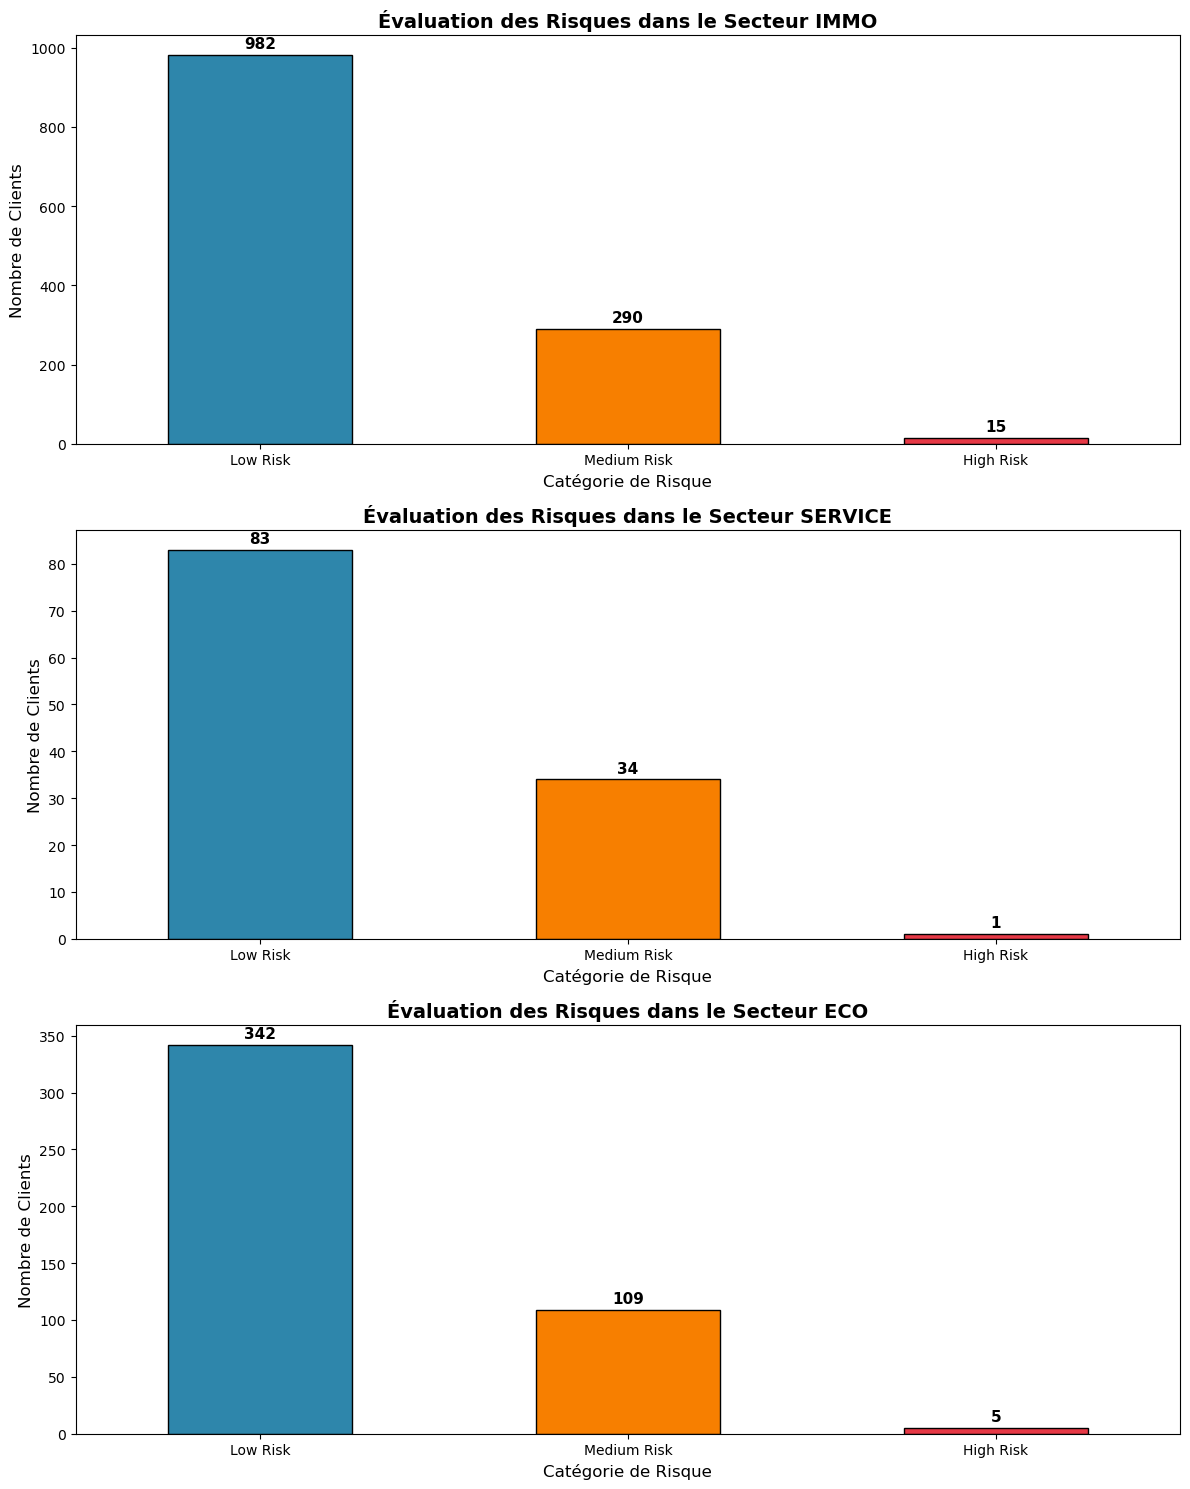

In [17]:
# Visualize risk assessment by sector
visualizer = Visualizer(risk_data)
visualizer.plot_risk_assesment_by_sector()

# Risk score statistics
if 'risk_score' in risk_data.columns:
    print("\n⚠️ Risk Score Statistics:")
    print(risk_data['risk_score'].describe())
    
    print("\nRisk Distribution by Sector:")
    if 'SECTOR' in risk_data.columns:
        risk_by_sector = risk_data.groupby('SECTOR')['risk_score'].agg(['mean', 'median', 'std', 'count'])
        print(risk_by_sector)

In [18]:
# Identify high-risk clients
print("🚨 Identifying high-risk clients...")
high_risk_clients = risk_analyzer.find_high_risk_clients()

if high_risk_clients is not None:
    print(f"\nNumber of high-risk clients identified: {len(high_risk_clients)}")
    print("\nHigh-risk clients preview:")
    print(high_risk_clients["SURVEY_ID"].head(10))
else:
    print("No high-risk clients data returned")

🚨 Identifying high-risk clients...

Number of high-risk clients identified: 21

High-risk clients preview:
226      3810036
673      4688996
1316     6416017
5257     8431270
5765     9847161
5826     9887892
6072    10004382
6084    10004719
6371    10162277
6623    10842428
Name: SURVEY_ID, dtype: int64
